# Imports and Functions

In [1]:
import math 
from sklearn.neural_network import MLPClassifier
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model
global threshold_low
global threshold_high
threshold_low = -500
threshold_high = 0
import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 3 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-512+(((x+5)*(512--512))/(51+5)))
def ynew(y): 
    return (-512+(((y+2)*(512--512))/(53+2)))

def eggholder(x):
       
    return (-(x[1]+47)*(math.sin(math.sqrt(abs((x[0]/2)+(x[1]+47))))))-((x[0])*(math.sin(math.sqrt(abs((x[0])+(x[1]+47))))))

def eggholderColor(x, threshold_low, threshold_high):
    
    if threshold_low < eggholder((xnew(x[0]),xnew(x[1]))) <threshold_high:
        return 1
    else:
        return 0

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zeggholder
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zeggholder = []
    eggholdercoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zeggholder.append(eggholderColor(eggholdercoords[i],threshold_low,threshold_high))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zeggholder)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
#     find0_5()
#     find_isolated_point()
    
#     print(distfinal)
#     print(probfinal)
#     print(score)
#     print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


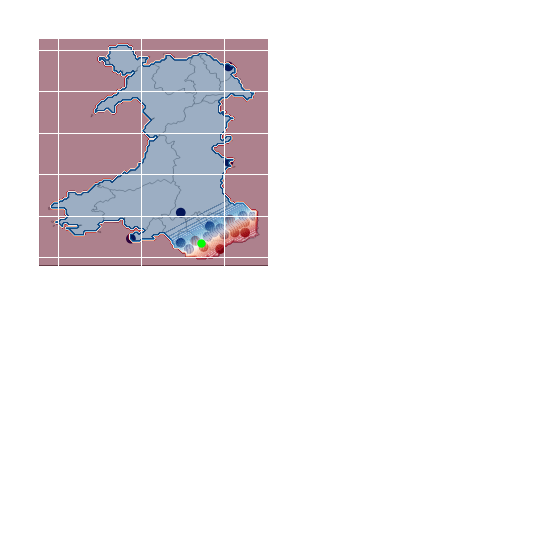

iteration  1
Accuracy is 0.5049029032878293
iteration  2
Accuracy is 0.5193232070755623
iteration  3
Accuracy is 0.5031724668333013
iteration  4
Accuracy is 0.5056719861565083
iteration  5
Accuracy is 0.4962507210151894
iteration  6
Accuracy is 0.5072101518938665
iteration  7
Accuracy is 0.5091328590655643
iteration  8
Accuracy is 0.5081715054797155
iteration  9
Accuracy is 0.5095174004999039
iteration  10
Accuracy is 0.5099019419342434
iteration  11
Accuracy is 0.5079792347625457
iteration  12
Accuracy is 0.5108632955200922
iteration  13
Accuracy is 0.5106710248029225
iteration  14
Accuracy is 0.5097096712170737
iteration  15
Accuracy is 0.5106710248029225
iteration  16
Accuracy is 0.5095174004999039
iteration  17
Accuracy is 0.5091328590655643
iteration  18
Accuracy is 0.5083637761968852
iteration  19
Accuracy is 0.5097096712170737
iteration  20
Accuracy is 0.510286483368583
iteration  21
Accuracy is 0.5097096712170737
experiment:  1


<IPython.core.display.Javascript object>


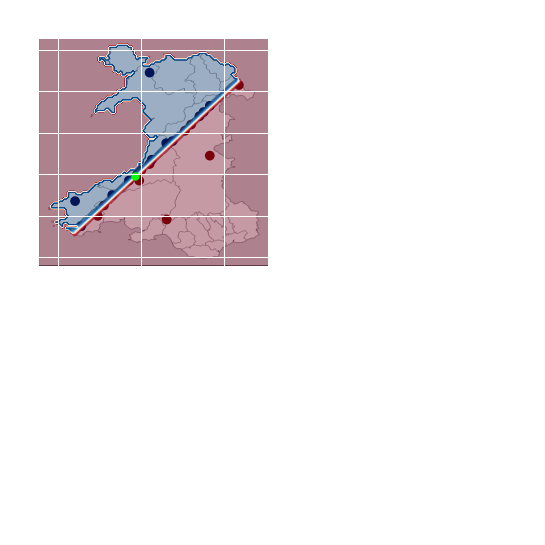

iteration  1
Accuracy is 0.5368198423380119
iteration  2
Accuracy is 0.5247067871563161
iteration  3
Accuracy is 0.5022111132474524
iteration  4
Accuracy is 0.5116323783887714
iteration  5
Accuracy is 0.5027879253989618
iteration  6
Accuracy is 0.5029801961161315
iteration  7
Accuracy is 0.5010574889444338
iteration  8
Accuracy is 0.5012497596616036
iteration  9
Accuracy is 0.499134781772736
iteration  10
Accuracy is 0.4979811574697174
iteration  11
Accuracy is 0.4993270524899058
iteration  12
Accuracy is 0.5002884060757546
iteration  13
Accuracy is 0.499134781772736
iteration  14
Accuracy is 0.49855796962122667
iteration  15
Accuracy is 0.49951932320707554
iteration  16
Accuracy is 0.49971159392424536
iteration  17
Accuracy is 0.5000961353585849
iteration  18
Accuracy is 0.49951932320707554
iteration  19
Accuracy is 0.49971159392424536
iteration  20
Accuracy is 0.4999038646414151
iteration  21
Accuracy is 0.49971159392424536
experiment:  2


<IPython.core.display.Javascript object>


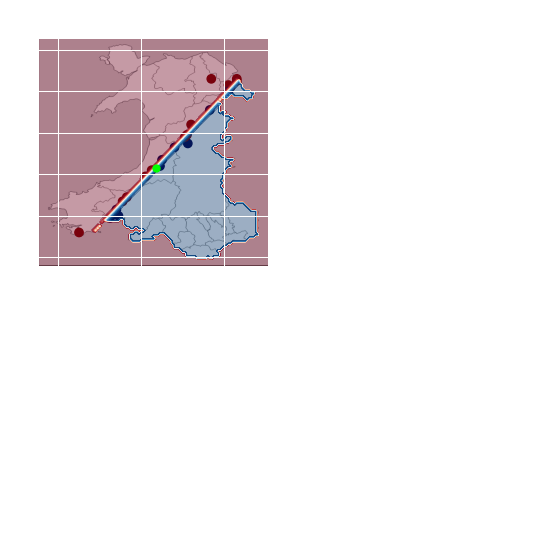

iteration  1
Accuracy is 0.4983656989040569
iteration  2
Accuracy is 0.4916362238031148
iteration  3
Accuracy is 0.4935589309748125
iteration  4
Accuracy is 0.49490482599500096
iteration  5
Accuracy is 0.4964429917323592
iteration  6
Accuracy is 0.49259757738896365
iteration  7
Accuracy is 0.4947125552778312
iteration  8
Accuracy is 0.49778888675254757
iteration  9
Accuracy is 0.4979811574697174
iteration  10
Accuracy is 0.4972120746010383
iteration  11
Accuracy is 0.49778888675254757
iteration  12
Accuracy is 0.4975966160353778
iteration  13
Accuracy is 0.49778888675254757
iteration  14
Accuracy is 0.4975966160353778
iteration  15
Accuracy is 0.49778888675254757
iteration  16
Accuracy is 0.4975966160353778
iteration  17
Accuracy is 0.49855796962122667
iteration  18
Accuracy is 0.49778888675254757
iteration  19
Accuracy is 0.4952893674293405
iteration  20
Accuracy is 0.49663526244952894
iteration  21
Accuracy is 0.49586617958084983
experiment:  3


<IPython.core.display.Javascript object>


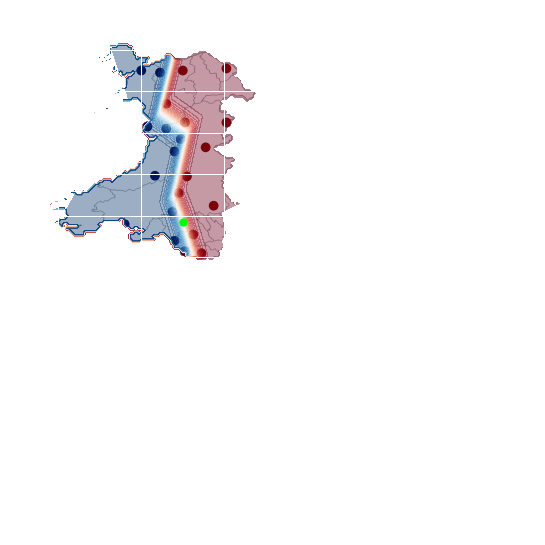

iteration  1
Accuracy is 0.5016343010959431
iteration  2
Accuracy is 0.5193232070755623
iteration  3
Accuracy is 0.5427802345702749
iteration  4
Accuracy is 0.5254758700249952
iteration  5
Accuracy is 0.5408575273985772
iteration  6
Accuracy is 0.5293212843683907
iteration  7
Accuracy is 0.5308594501057489
iteration  8
Accuracy is 0.5385502787925399
iteration  9
Accuracy is 0.5343203230148048
iteration  10
Accuracy is 0.5416266102672563
iteration  11
Accuracy is 0.5366275716208422
iteration  12
Accuracy is 0.5441261295904634
iteration  13
Accuracy is 0.5450874831763123
iteration  14
Accuracy is 0.5445106710248029
iteration  15
Accuracy is 0.5456642953278216
iteration  16
Accuracy is 0.5485483560853682
iteration  17
Accuracy is 0.5479715439338588
iteration  18
Accuracy is 0.549509709671217
iteration  19
Accuracy is 0.5520092289944242
iteration  20
Accuracy is 0.5500865218227264
iteration  21
Accuracy is 0.5498942511055567
experiment:  4


<IPython.core.display.Javascript object>


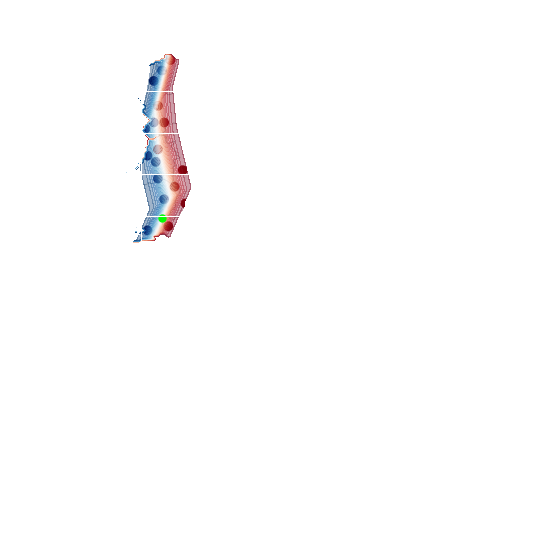

iteration  1
Accuracy is 0.49009805806575657
iteration  2
Accuracy is 0.5248990578734859
iteration  3
Accuracy is 0.5443184003076331
iteration  4
Accuracy is 0.5379734666410305
iteration  5
Accuracy is 0.5414343395500866
iteration  6
Accuracy is 0.5383580080753702
iteration  7
Accuracy is 0.5200922899442415
iteration  8
Accuracy is 0.5443184003076331
iteration  9
Accuracy is 0.5479715439338588
iteration  10
Accuracy is 0.5416266102672563
iteration  11
Accuracy is 0.5460488367621611
iteration  12
Accuracy is 0.5458565660449913
iteration  13
Accuracy is 0.5462411074793309
iteration  14
Accuracy is 0.5448952124591425
iteration  15
Accuracy is 0.5433570467217843
iteration  16
Accuracy is 0.5468179196308403
iteration  17
Accuracy is 0.5464333781965006
iteration  18
Accuracy is 0.5481638146510287
iteration  19
Accuracy is 0.5508556046914055
iteration  20
Accuracy is 0.5514324168429148
iteration  21
Accuracy is 0.5516246875600846
experiment:  5


<IPython.core.display.Javascript object>


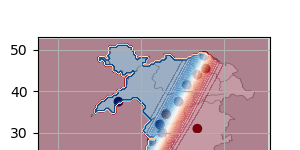

iteration  1
Accuracy is 0.47510094212651416
iteration  2
Accuracy is 0.48817535089405883
iteration  3
Accuracy is 0.48567583157085176
iteration  4
Accuracy is 0.5070178811766968
iteration  5
Accuracy is 0.5139396269948087
iteration  6
Accuracy is 0.5216304556815997
iteration  7
Accuracy is 0.5245145164391464
iteration  8
Accuracy is 0.5243222457219765
iteration  9
Accuracy is 0.525668140742165
iteration  10
Accuracy is 0.5258604114593347
iteration  11
Accuracy is 0.5273985771966929
iteration  12
Accuracy is 0.525668140742165
iteration  13
Accuracy is 0.523937704287637
iteration  14
Accuracy is 0.5275908479138627
iteration  15
Accuracy is 0.5245145164391464
iteration  16
Accuracy is 0.5250913285906557
iteration  17
Accuracy is 0.5264372236108441
iteration  18
Accuracy is 0.5285522014997116
iteration  19
Accuracy is 0.5289367429340511
iteration  20
Accuracy is 0.5314362622572583
iteration  21
Accuracy is 0.5304749086714093
experiment:  6


<IPython.core.display.Javascript object>


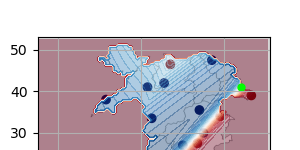

iteration  1
Accuracy is 0.5323976158431071
iteration  2
Accuracy is 0.5491251682368775
iteration  3
Accuracy is 0.5298980965199
iteration  4
Accuracy is 0.5318208036915978
iteration  5
Accuracy is 0.5445106710248029
iteration  6
Accuracy is 0.5183618534897135
iteration  7
Accuracy is 0.5074024226110363
iteration  8
Accuracy is 0.5116323783887714
iteration  9
Accuracy is 0.5095174004999039
iteration  10
Accuracy is 0.5099019419342434
iteration  11
Accuracy is 0.5058642568736781
iteration  12
Accuracy is 0.5122091905402807
iteration  13
Accuracy is 0.5106710248029225
iteration  14
Accuracy is 0.5095174004999039
iteration  15
Accuracy is 0.5087483176312247
iteration  16
Accuracy is 0.5106710248029225
iteration  17
Accuracy is 0.508556046914055
iteration  18
Accuracy is 0.5114401076716016
iteration  19
Accuracy is 0.5118246491059412
iteration  20
Accuracy is 0.5125937319746202
iteration  21
Accuracy is 0.5097096712170737
experiment:  7


<IPython.core.display.Javascript object>


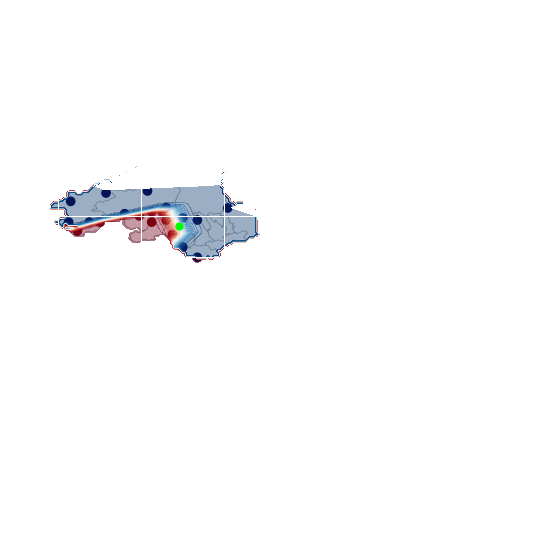

iteration  1
Accuracy is 0.4685637377427418
iteration  2
Accuracy is 0.47337050567198613
iteration  3
Accuracy is 0.485483560853682
iteration  4
Accuracy is 0.48932897519707746
iteration  5
Accuracy is 0.5012497596616036
iteration  6
Accuracy is 0.4862526437223611
iteration  7
Accuracy is 0.4845222072678331
iteration  8
Accuracy is 0.4950970967121707
iteration  9
Accuracy is 0.4699096327629302
iteration  10
Accuracy is 0.4758700249951932
iteration  11
Accuracy is 0.4810613343587772
iteration  12
Accuracy is 0.48894443376273794
iteration  13
Accuracy is 0.4875985387425495
iteration  14
Accuracy is 0.4950970967121707
iteration  15
Accuracy is 0.499134781772736
iteration  16
Accuracy is 0.500865218227264
iteration  17
Accuracy is 0.5022111132474524
iteration  18
Accuracy is 0.5022111132474524
iteration  19
Accuracy is 0.5024033839646221
iteration  20
Accuracy is 0.5058642568736781
iteration  21
Accuracy is 0.5027879253989618
experiment:  8


<IPython.core.display.Javascript object>


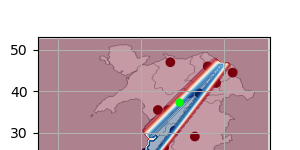

iteration  1
Accuracy is 0.5054797154393386
iteration  2
Accuracy is 0.5273985771966929
iteration  3
Accuracy is 0.5477792732166891
iteration  4
Accuracy is 0.5175927706210344
iteration  5
Accuracy is 0.4954816381465103
iteration  6
Accuracy is 0.49125168236877526
iteration  7
Accuracy is 0.5037492789848106
iteration  8
Accuracy is 0.5187463949240531
iteration  9
Accuracy is 0.5075946933282061
iteration  10
Accuracy is 0.5029801961161315
iteration  11
Accuracy is 0.5091328590655643
iteration  12
Accuracy is 0.5083637761968852
iteration  13
Accuracy is 0.5056719861565083
iteration  14
Accuracy is 0.5037492789848106
iteration  15
Accuracy is 0.506056527590848
iteration  16
Accuracy is 0.5075946933282061
iteration  17
Accuracy is 0.5089405883483945
iteration  18
Accuracy is 0.5087483176312247
iteration  19
Accuracy is 0.5074024226110363
iteration  20
Accuracy is 0.5070178811766968
iteration  21
Accuracy is 0.5077869640453759
experiment:  9


<IPython.core.display.Javascript object>


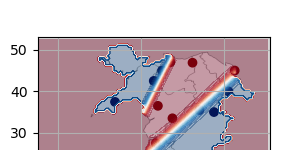

iteration  1
Accuracy is 0.5325898865602768
iteration  2
Accuracy is 0.5279753893482023
iteration  3
Accuracy is 0.5383580080753702
iteration  4
Accuracy is 0.5379734666410305
iteration  5
Accuracy is 0.5493174389540473
iteration  6
Accuracy is 0.5308594501057489
iteration  7
Accuracy is 0.5283599307825418
iteration  8
Accuracy is 0.5323976158431071
iteration  9
Accuracy is 0.5329744279946165
iteration  10
Accuracy is 0.5323976158431071
iteration  11
Accuracy is 0.5364353009036724
iteration  12
Accuracy is 0.5400884445298981
iteration  13
Accuracy is 0.5406652566814074
iteration  14
Accuracy is 0.5400884445298981
iteration  15
Accuracy is 0.5410497981157469
iteration  16
Accuracy is 0.5370121130551817
iteration  17
Accuracy is 0.5389348202268794
iteration  18
Accuracy is 0.5398961738127284
iteration  19
Accuracy is 0.5416266102672563
iteration  20
Accuracy is 0.5389348202268794
iteration  21
Accuracy is 0.539319361661219
experiment:  10


<IPython.core.display.Javascript object>


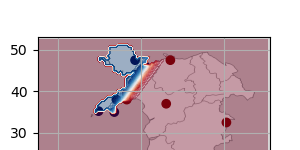

iteration  1
Accuracy is 0.4850990194193424
iteration  2
Accuracy is 0.5127860026917901
iteration  3
Accuracy is 0.5295135550855604
iteration  4
Accuracy is 0.5237454335704672
iteration  5
Accuracy is 0.5216304556815997
iteration  6
Accuracy is 0.5158623341665064
iteration  7
Accuracy is 0.5120169198231109
iteration  8
Accuracy is 0.5183618534897135
iteration  9
Accuracy is 0.5175927706210344
iteration  10
Accuracy is 0.5174004999038646
iteration  11
Accuracy is 0.5187463949240531
iteration  12
Accuracy is 0.519707748509902
iteration  13
Accuracy is 0.5191309363583926
iteration  14
Accuracy is 0.5195154777927322
iteration  15
Accuracy is 0.5210536435300903
iteration  16
Accuracy is 0.5220149971159392
iteration  17
Accuracy is 0.5231686214189579
iteration  18
Accuracy is 0.525668140742165
iteration  19
Accuracy is 0.5237454335704672
iteration  20
Accuracy is 0.5243222457219765
iteration  21
Accuracy is 0.5193232070755623
experiment:  11


<IPython.core.display.Javascript object>


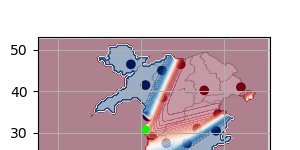

iteration  1
Accuracy is 0.4979811574697174
iteration  2
Accuracy is 0.5104787540857527
iteration  3
Accuracy is 0.5139396269948087
iteration  4
Accuracy is 0.510286483368583
iteration  5
Accuracy is 0.5147087098634878
iteration  6
Accuracy is 0.5122091905402807
iteration  7
Accuracy is 0.5158623341665064
iteration  8
Accuracy is 0.5223995385502788
iteration  9
Accuracy is 0.5212459142472602
iteration  10
Accuracy is 0.5212459142472602
iteration  11
Accuracy is 0.5231686214189579
iteration  12
Accuracy is 0.5266294943280139
iteration  13
Accuracy is 0.5281676600653721
iteration  14
Accuracy is 0.534128052297635
iteration  15
Accuracy is 0.5314362622572583
iteration  16
Accuracy is 0.5298980965199
iteration  17
Accuracy is 0.5260526821765045
iteration  18
Accuracy is 0.5362430301865025
iteration  19
Accuracy is 0.5295135550855604
iteration  20
Accuracy is 0.5247067871563161
iteration  21
Accuracy is 0.5283599307825418
experiment:  12


<IPython.core.display.Javascript object>


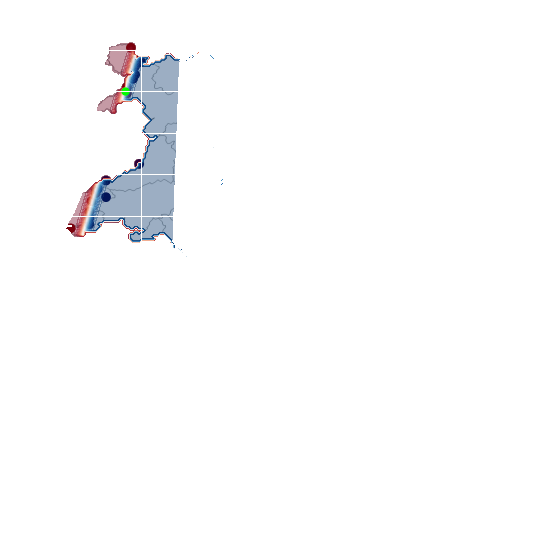

iteration  1
Accuracy is 0.4729859642376466
iteration  2
Accuracy is 0.4629878869448183
iteration  3
Accuracy is 0.47952316862141897
iteration  4
Accuracy is 0.46279561622764853
iteration  5
Accuracy is 0.4697173620457604
iteration  6
Accuracy is 0.46875600845991156
iteration  7
Accuracy is 0.47279369352047684
iteration  8
Accuracy is 0.4747164006921746
iteration  9
Accuracy is 0.4754854835608537
iteration  10
Accuracy is 0.4739473178234955
iteration  11
Accuracy is 0.4754854835608537
iteration  12
Accuracy is 0.47567775427802345
iteration  13
Accuracy is 0.47510094212651416
iteration  14
Accuracy is 0.4745241299750048
iteration  15
Accuracy is 0.4754854835608537
iteration  16
Accuracy is 0.47567775427802345
iteration  17
Accuracy is 0.476062295712363
iteration  18
Accuracy is 0.4762545664295328
iteration  19
Accuracy is 0.47683137858104213
iteration  20
Accuracy is 0.4799077100557585
iteration  21
Accuracy is 0.4766391078638723
experiment:  13


<IPython.core.display.Javascript object>


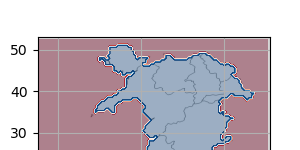

iteration  1
Accuracy is 0.5012497596616036
iteration  2
Accuracy is 0.5056719861565083
iteration  3
Accuracy is 0.502595654681792
iteration  4
Accuracy is 0.5047106325706595
iteration  5
Accuracy is 0.5031724668333013
iteration  6
Accuracy is 0.5031724668333013
iteration  7
Accuracy is 0.5033647375504711
iteration  8
Accuracy is 0.5033647375504711
iteration  9
Accuracy is 0.5031724668333013
iteration  10
Accuracy is 0.5029801961161315
iteration  11
Accuracy is 0.5022111132474524
iteration  12
Accuracy is 0.5029801961161315
iteration  13
Accuracy is 0.5027879253989618
iteration  14
Accuracy is 0.5029801961161315
iteration  15
Accuracy is 0.5037492789848106
iteration  16
Accuracy is 0.5035570082676408
iteration  17
Accuracy is 0.5035570082676408
iteration  18
Accuracy is 0.5031724668333013
iteration  19
Accuracy is 0.5033647375504711
iteration  20
Accuracy is 0.5029801961161315
iteration  21
Accuracy is 0.5033647375504711
experiment:  14


<IPython.core.display.Javascript object>


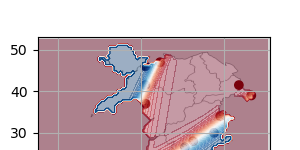

iteration  1
Accuracy is 0.4622188040761392
iteration  2
Accuracy is 0.5212459142472602
iteration  3
Accuracy is 0.5283599307825418
iteration  4
Accuracy is 0.5345125937319746
iteration  5
Accuracy is 0.5285522014997116
iteration  6
Accuracy is 0.5304749086714093
iteration  7
Accuracy is 0.5264372236108441
iteration  8
Accuracy is 0.5306671793885791
iteration  9
Accuracy is 0.531628532974428
iteration  10
Accuracy is 0.5320130744087676
iteration  11
Accuracy is 0.5318208036915978
iteration  12
Accuracy is 0.5327821572774466
iteration  13
Accuracy is 0.5260526821765045
iteration  14
Accuracy is 0.5331666987117862
iteration  15
Accuracy is 0.5302826379542396
iteration  16
Accuracy is 0.5302826379542396
iteration  17
Accuracy is 0.5318208036915978
iteration  18
Accuracy is 0.531628532974428
iteration  19
Accuracy is 0.5310517208229186
iteration  20
Accuracy is 0.5327821572774466
iteration  21
Accuracy is 0.5356662180349933
experiment:  15


<IPython.core.display.Javascript object>


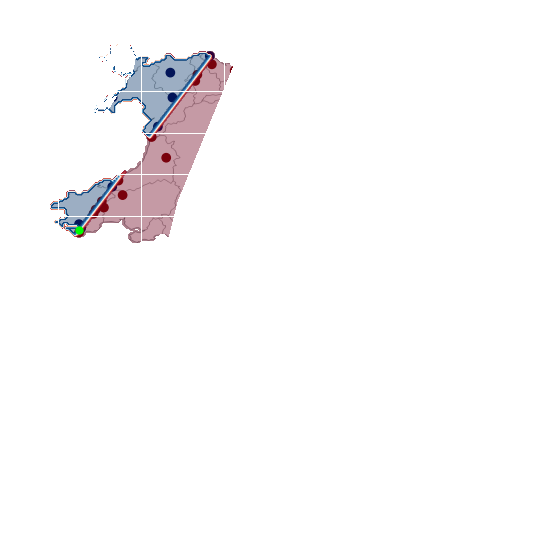

iteration  1
Accuracy is 0.5070178811766968
iteration  2
Accuracy is 0.5281676600653721
iteration  3
Accuracy is 0.5445106710248029
iteration  4
Accuracy is 0.533358969428956
iteration  5
Accuracy is 0.5281676600653721
iteration  6
Accuracy is 0.5289367429340511
iteration  7
Accuracy is 0.5223995385502788
iteration  8
Accuracy is 0.5262449528936743
iteration  9
Accuracy is 0.5237454335704672
iteration  10
Accuracy is 0.5235531628532974
iteration  11
Accuracy is 0.5250913285906557
iteration  12
Accuracy is 0.5247067871563161
iteration  13
Accuracy is 0.5229763507017882
iteration  14
Accuracy is 0.5237454335704672
iteration  15
Accuracy is 0.5227840799846183
iteration  16
Accuracy is 0.5233608921361277
iteration  17
Accuracy is 0.5229763507017882
iteration  18
Accuracy is 0.5233608921361277
iteration  19
Accuracy is 0.5233608921361277
iteration  20
Accuracy is 0.5235531628532974
iteration  21
Accuracy is 0.5233608921361277
experiment:  16


<IPython.core.display.Javascript object>


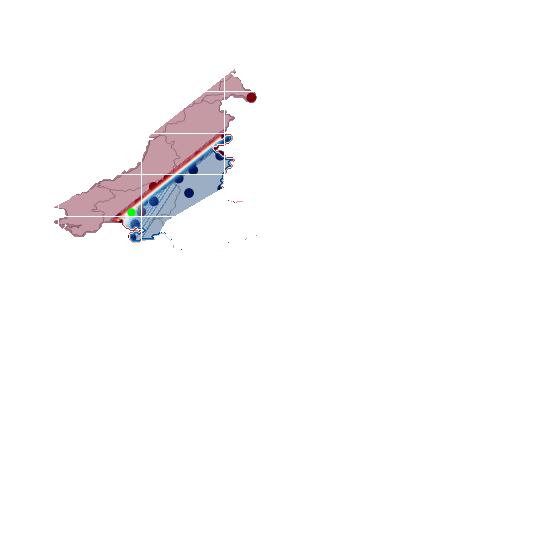

iteration  1
Accuracy is 0.5145164391463181
iteration  2
Accuracy is 0.5150932512978273
iteration  3
Accuracy is 0.49740434531820804
iteration  4
Accuracy is 0.5016343010959431
iteration  5
Accuracy is 0.49778888675254757
iteration  6
Accuracy is 0.49778888675254757
iteration  7
Accuracy is 0.4950970967121707
iteration  8
Accuracy is 0.49336666025764275
iteration  9
Accuracy is 0.4939434724091521
iteration  10
Accuracy is 0.4947125552778312
iteration  11
Accuracy is 0.4950970967121707
iteration  12
Accuracy is 0.4950970967121707
iteration  13
Accuracy is 0.49490482599500096
iteration  14
Accuracy is 0.4947125552778312
iteration  15
Accuracy is 0.4962507210151894
iteration  16
Accuracy is 0.49567390886368007
iteration  17
Accuracy is 0.49586617958084983
iteration  18
Accuracy is 0.4968275331666987
iteration  19
Accuracy is 0.4952893674293405
iteration  20
Accuracy is 0.4952893674293405
iteration  21
Accuracy is 0.4954816381465103
experiment:  17


<IPython.core.display.Javascript object>


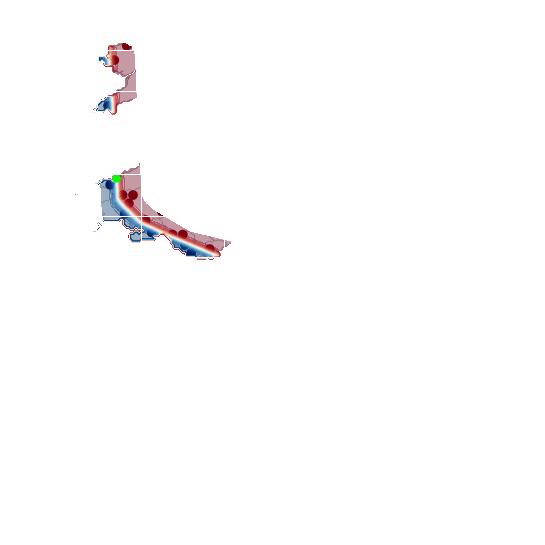

iteration  1
Accuracy is 0.5481638146510287
iteration  2
Accuracy is 0.535858488752163
iteration  3
Accuracy is 0.5227840799846183
iteration  4
Accuracy is 0.5216304556815997
iteration  5
Accuracy is 0.5177850413382042
iteration  6
Accuracy is 0.5168236877523553
iteration  7
Accuracy is 0.4927898481061334
iteration  8
Accuracy is 0.5118246491059412
iteration  9
Accuracy is 0.5320130744087676
iteration  10
Accuracy is 0.5568159969236686
iteration  11
Accuracy is 0.5460488367621611
iteration  12
Accuracy is 0.5464333781965006
iteration  13
Accuracy is 0.5550855604691406
iteration  14
Accuracy is 0.5502787925398962
iteration  15
Accuracy is 0.5481638146510287
iteration  16
Accuracy is 0.5493174389540473
iteration  17
Accuracy is 0.554701019034801
iteration  18
Accuracy is 0.5533551240146126
iteration  19
Accuracy is 0.5527783118631032
iteration  20
Accuracy is 0.5593155162468756
iteration  21
Accuracy is 0.5639300134589502
experiment:  18


<IPython.core.display.Javascript object>


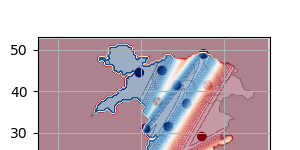

iteration  1
Accuracy is 0.5139396269948087
iteration  2
Accuracy is 0.5385502787925399
iteration  3
Accuracy is 0.5489328975197078
iteration  4
Accuracy is 0.5425879638531051
iteration  5
Accuracy is 0.5406652566814074
iteration  6
Accuracy is 0.5410497981157469
iteration  7
Accuracy is 0.5414343395500866
iteration  8
Accuracy is 0.5420111517015959
iteration  9
Accuracy is 0.5473947317823495
iteration  10
Accuracy is 0.548740626802538
iteration  11
Accuracy is 0.5391270909440492
iteration  12
Accuracy is 0.5462411074793309
iteration  13
Accuracy is 0.548740626802538
iteration  14
Accuracy is 0.5447029417419726
iteration  15
Accuracy is 0.5450874831763123
iteration  16
Accuracy is 0.5435493174389541
iteration  17
Accuracy is 0.5443184003076331
iteration  18
Accuracy is 0.5477792732166891
iteration  19
Accuracy is 0.5397039030955586
iteration  20
Accuracy is 0.5354739473178235
iteration  21
Accuracy is 0.5343203230148048
experiment:  19


<IPython.core.display.Javascript object>


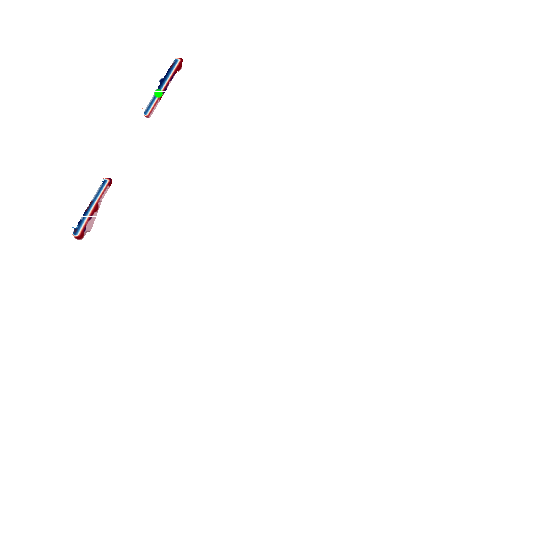

iteration  1
Accuracy is 0.5285522014997116
iteration  2
Accuracy is 0.5325898865602768
iteration  3
Accuracy is 0.5306671793885791
iteration  4
Accuracy is 0.5318208036915978
iteration  5
Accuracy is 0.5308594501057489
iteration  6
Accuracy is 0.5318208036915978
iteration  7
Accuracy is 0.5308594501057489
iteration  8
Accuracy is 0.5308594501057489
iteration  9
Accuracy is 0.5312439915400884
iteration  10
Accuracy is 0.5308594501057489
iteration  11
Accuracy is 0.5310517208229186
iteration  12
Accuracy is 0.5308594501057489
iteration  13
Accuracy is 0.5306671793885791
iteration  14
Accuracy is 0.5310517208229186
iteration  15
Accuracy is 0.5312439915400884
iteration  16
Accuracy is 0.5325898865602768
iteration  17
Accuracy is 0.5314362622572583
iteration  18
Accuracy is 0.5312439915400884
iteration  19
Accuracy is 0.5312439915400884
iteration  20
Accuracy is 0.5308594501057489
iteration  21
Accuracy is 0.5314362622572583
experiment:  20


<IPython.core.display.Javascript object>


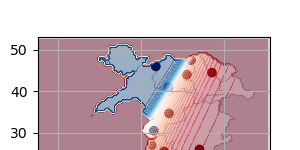

iteration  1
Accuracy is 0.5125937319746202
iteration  2
Accuracy is 0.5114401076716016
iteration  3
Accuracy is 0.4822149586617958
iteration  4
Accuracy is 0.5089405883483945
iteration  5
Accuracy is 0.516246875600846
iteration  6
Accuracy is 0.5208613728129206
iteration  7
Accuracy is 0.5360507594693328
iteration  8
Accuracy is 0.5387425495097097
iteration  9
Accuracy is 0.5402807152470679
iteration  10
Accuracy is 0.5408575273985772
iteration  11
Accuracy is 0.5250913285906557
iteration  12
Accuracy is 0.5379734666410305
iteration  13
Accuracy is 0.5331666987117862
iteration  14
Accuracy is 0.5325898865602768
iteration  15
Accuracy is 0.5335512401461258
iteration  16
Accuracy is 0.5385502787925399
iteration  17
Accuracy is 0.5377811959238608
iteration  18
Accuracy is 0.5372043837723515
iteration  19
Accuracy is 0.5391270909440492
iteration  20
Accuracy is 0.5379734666410305
iteration  21
Accuracy is 0.5279753893482023


In [7]:
from random import randint
import time

valid_seeds = [12,15,17,21,23,24,25,31,35,36,37,41,43,45,49,52,55,56,57,58,59]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            eggholderColor(landpoints[value],threshold_low,threshold_high)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], eggholderColor(nextpoint,threshold_low,threshold_high)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 54.09 %
Improvement is = 2.83 %


In [9]:
Results

[[0.5049029032878293,
  0.5193232070755623,
  0.5031724668333013,
  0.5056719861565083,
  0.4962507210151894,
  0.5072101518938665,
  0.5091328590655643,
  0.5081715054797155,
  0.5095174004999039,
  0.5099019419342434,
  0.5079792347625457,
  0.5108632955200922,
  0.5106710248029225,
  0.5097096712170737,
  0.5106710248029225,
  0.5095174004999039,
  0.5091328590655643,
  0.5083637761968852,
  0.5097096712170737,
  0.510286483368583,
  0.5097096712170737],
 [0.5368198423380119,
  0.5247067871563161,
  0.5022111132474524,
  0.5116323783887714,
  0.5027879253989618,
  0.5029801961161315,
  0.5010574889444338,
  0.5012497596616036,
  0.499134781772736,
  0.4979811574697174,
  0.4993270524899058,
  0.5002884060757546,
  0.499134781772736,
  0.49855796962122667,
  0.49951932320707554,
  0.49971159392424536,
  0.5000961353585849,
  0.49951932320707554,
  0.49971159392424536,
  0.4999038646414151,
  0.49971159392424536],
 [0.4983656989040569,
  0.4916362238031148,
  0.4935589309748125,
  0.4

In [10]:
np.savetxt('eggholder_bestnn', Results)